In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from my_nlp_module.bert_models import map_name_to_handle, map_model_to_preprocess
import gc
import numpy as np

from my_nlp_module.preprocessing import preprocess_bbc_for_bert_notebook, preprocess_bbc_to_dict, \
PrepOption, remove_dir
from my_nlp_module.metrics import Metrics


import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2022-12-11 22:47:06.354548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_train_path = "../datasets/bbc-text/train"
dataset_test_path = "../datasets/bbc-text/test"
preprocessed_train_path = "../datasets/preprocessed/bbc-text/train"
preprocessed_test_path = "../datasets/preprocessed/bbc-text/test"

# Poniżej należy odkomentować testowany zestaw wstępnego przetwarzania

#options = [PrepOption.STOPWORDS, PrepOption.LOWERCASE, PrepOption.LEMMA,
#           PrepOption.NUMBERS, PrepOption.RUBBISH]
options = [PrepOption.NUMBERS, PrepOption.RUBBISH]
preprocess_bbc_for_bert_notebook(dataset_train_path, preprocessed_train_path, options)
preprocess_bbc_for_bert_notebook(dataset_test_path, preprocessed_test_path, options)

Couldn't read 1 files:
../datasets/bbc-text/train/sport/199.txt

Couldn't read 0 files:



In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    preprocessed_train_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    preprocessed_train_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


test_ds = tf.keras.utils.text_dataset_from_directory(
    preprocessed_test_path,
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



preprocessed_tetst = preprocess_bbc_to_dict(dataset_test_path, options)
class_number = {}
for i, cls_n in enumerate(class_names):
    class_number[cls_n] = i
    
test_examples = []
test_labels = []

for key in preprocessed_tetst.keys():
    for doc in preprocessed_tetst[key]:
        test_examples.append(doc)
        test_labels.append(class_number[key])
test_labels = np.array(test_labels)

del preprocessed_tetst
gc.collect()
print(class_number)

Found 1999 files belonging to 5 classes.
Using 1600 files for training.


2022-12-11 22:47:18.946865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1999 files belonging to 5 classes.
Using 399 files for validation.
Found 225 files belonging to 5 classes.
Couldn't read 0 files:

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [4]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [6]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='wejście_tekstowe')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_przetwarzanie')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_enkoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(10, activation="relu", name='warstwa_ukryta')(net)
    net = tf.keras.layers.Dense(5, activation="softmax", name='klasyfikator')(net)
    return tf.keras.Model(text_input, net)

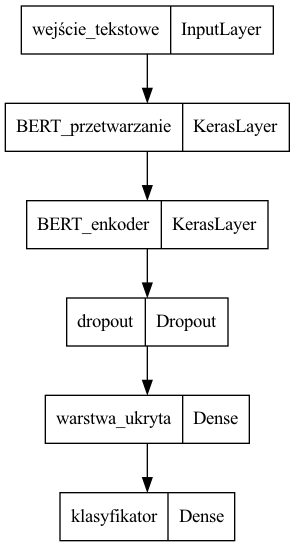

In [7]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [8]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [9]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
init_lr = 3e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=init_lr,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)

optimizer1 = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule)

selected_optimizer = "optimizer1"
optimizers = {
    "optimizer1": optimizer1,
    "adam": "adam",
    "sgd": "sgd"
}

classifier_model.compile(optimizer=optimizers[selected_optimizer],
                         loss=loss,
                         metrics=metrics)

In [10]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
50/50 [==============================] - 145s 3s/step - loss: 1.0833 - sparse_categorical_accuracy: 0.4781 - val_loss: 0.6825 - val_sparse_categorical_accuracy: 0.7644
Epoch 2/5
50/50 [==============================] - 134s 3s/step - loss: 0.5168 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.3666 - val_sparse_categorical_accuracy: 0.8571
Epoch 3/5
50/50 [==============================] - 135s 3s/step - loss: 0.3277 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.2844 - val_sparse_categorical_accuracy: 0.9524
Epoch 4/5
50/50 [==============================] - 135s 3s/step - loss: 0.2653 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.2792 - val_sparse_categorical_accuracy: 0.9524
Epoch 5/5
50/50 [==============================] - 135s 3s/step - loss: 0.2376 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.2663 - val_sparse_categorical_accuracy: 0.9599


In [11]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Funkcja kosztu na zbiorze testowym: {loss}')
print(f'Dokładność na zbiorze testowym: {accuracy}\n\n')

def predict_function(model, x):
    result = []
    outputs = model(tf.constant(x))
    for out in outputs:
        class_number = int(tf.math.argmax(out))
        result.append(class_number)
    return np.array(result)

metrics = Metrics(classifier_model, predict_function)
print("Metryki dla zbioru testowego")
_ = metrics.accuracy(test_examples, test_labels)
_ = metrics.precision(test_examples, test_labels)
_ = metrics.recall(test_examples, test_labels)
_ = metrics.f1(test_examples, test_labels)

8/8 [==============================] - 6s 698ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9467
Funkcja kosztu na zbiorze testowym: 0.24192549288272858
Dokładność na zbiorze testowym: 0.9466666579246521


Metryki dla zbioru testowego
Dokładność: 0.9466666666666667
Precyzja: [0.97619048 0.8125     1.         0.96296296 1.        ]
Czułość: [0.80392157 1.         0.97619048 1.         0.97560976]
F1: [0.88172043 0.89655172 0.98795181 0.98113208 0.98765432]


In [12]:
metrics.print_confusion_matrix(test_examples, test_labels)
metrics.print_metrics(test_examples, test_labels)

[[41  9  0  1  0]
 [ 0 39  0  0  0]
 [ 1  0 41  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  1 40]]
╒═══════╤═══════╤═══════╤═══════╤═══════╕
│ 0.976 │ 0.812 │ 1     │ 0.963 │ 1     │
├───────┼───────┼───────┼───────┼───────┤
│ 0.804 │ 1     │ 0.976 │ 1     │ 0.976 │
├───────┼───────┼───────┼───────┼───────┤
│ 0.882 │ 0.897 │ 0.988 │ 0.981 │ 0.988 │
╘═══════╧═══════╧═══════╧═══════╧═══════╛
Dokładność: 0.947


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


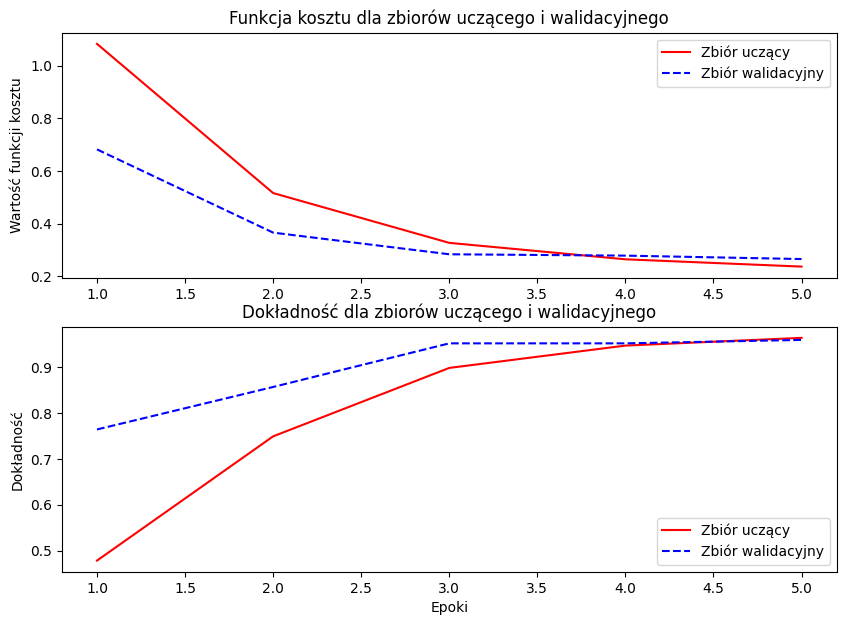

In [13]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 7))
fig.tight_layout(pad=10)

plt.subplot(2, 1, 1)
plt.plot(epochs_range, loss, 'r', label='Zbiór uczący')
plt.plot(epochs_range, val_loss, '--b', label='Zbiór walidacyjny')
plt.title('Funkcja kosztu dla zbiorów uczącego i walidacyjnego')
plt.ylabel('Wartość funkcji kosztu')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, acc, 'r', label='Zbiór uczący')
plt.plot(epochs_range, val_acc, '--b', label='Zbiór walidacyjny')
plt.title('Dokładność dla zbiorów uczącego i walidacyjnego')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')

In [14]:
print(f"Parametry modelu:\nwstępne przetwarzanie: {options}\nilość epok: {epochs}\nmodel BERT: {bert_model_name}\nalgorytm optymalizacyjny: {selected_optimizer}")

Parametry modelu:
wstępne przetwarzanie: [<PrepOption.NUMBERS: 7>, <PrepOption.RUBBISH: 6>]
ilość epok: 5
model BERT: small_bert/bert_en_uncased_L-4_H-512_A-8
algorytm optymalizacyjny: optimizer1


In [15]:
current_dir = os.getcwd()
remove_dir(os.path.join(current_dir, '../datasets/preprocessed/bbc-text'))